In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lionitesh10","key":"599a4e291bdc48f809dc415625ea28ec"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 90% 108M/121M [00:02<00:00, 36.5MB/s]
100% 121M/121M [00:02<00:00, 42.5MB/s]


In [5]:
!unzip face-expression-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating: images/validation/fear/9606.jpg  
  inflating:

In [6]:
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
import matplotlib.pyplot as plt
import os
from keras.layers import Conv2D,BatchNormalization,Activation,Dropout,Flatten,Dense,MaxPooling2D
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import pydot
from keras.utils import plot_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


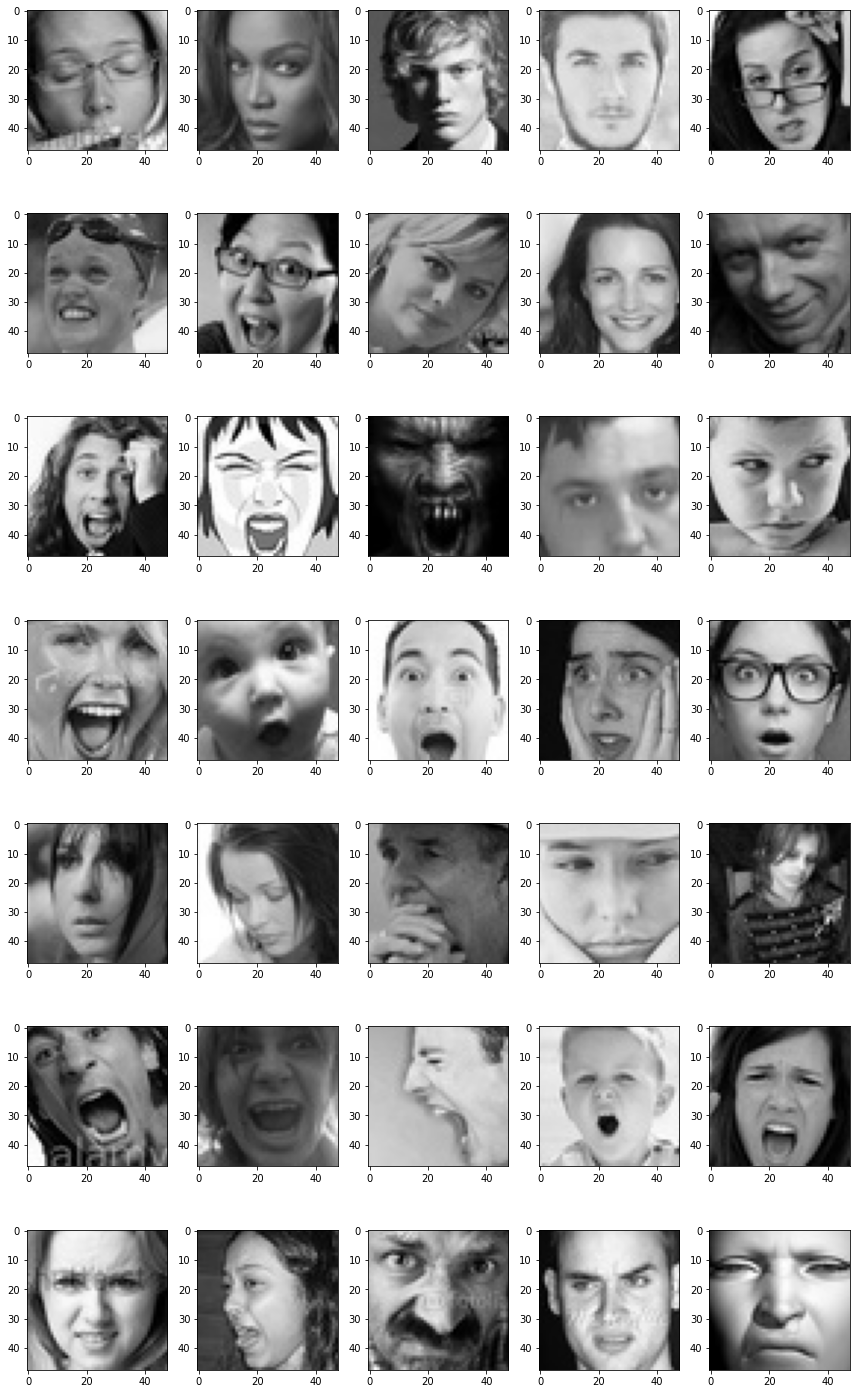

In [7]:
pic_size=48
base_path="/content/images/images/"
plt.figure(0,figsize=(12,20))
cpt=0

for expression in os.listdir(base_path+"train/"):
  for i in range(1,6):
    cpt+=1
    plt.subplot(7,5,cpt)
    img=load_img(base_path+"train/"+expression+"/"+os.listdir(base_path+"train/"+expression)[i],target_size=(pic_size,pic_size))
    plt.imshow(img,cmap="gray")
plt.tight_layout()
plt.show()

In [8]:
for expression in os.listdir(base_path+"train"):
  print(str(len(os.listdir(base_path+"train/"+expression)))+" "+expression+" images")

4982 neutral images
7164 happy images
4103 fear images
3205 surprise images
4938 sad images
3993 angry images
436 disgust images


In [9]:

datagen_train=ImageDataGenerator()
datagen_validation=ImageDataGenerator()

batch_size=128

train_gen=datagen_train.flow_from_directory(base_path+"train",
                                            target_size=(pic_size,pic_size),
                                            color_mode="grayscale",
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=True
                                            )
validation_gen=datagen_validation.flow_from_directory(base_path+"validation",
                                                      target_size=(pic_size,pic_size),
                                                      color_mode='grayscale',
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      shuffle=False
                                                      )

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [11]:
nb_classes=7
model=Sequential()

#1st Convolution Layer
model.add(Conv2D(64,(3,3),padding="same",input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2nd Convolution Layer
model.add(Conv2D(128,(5,5),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3rd Convolution Layer
model.add(Conv2D(512,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th Convolution Layer
model.add(Conv2D(512,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Flatten
model.add(Flatten())

#Fully Connected Layers
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes,activation='softmax'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

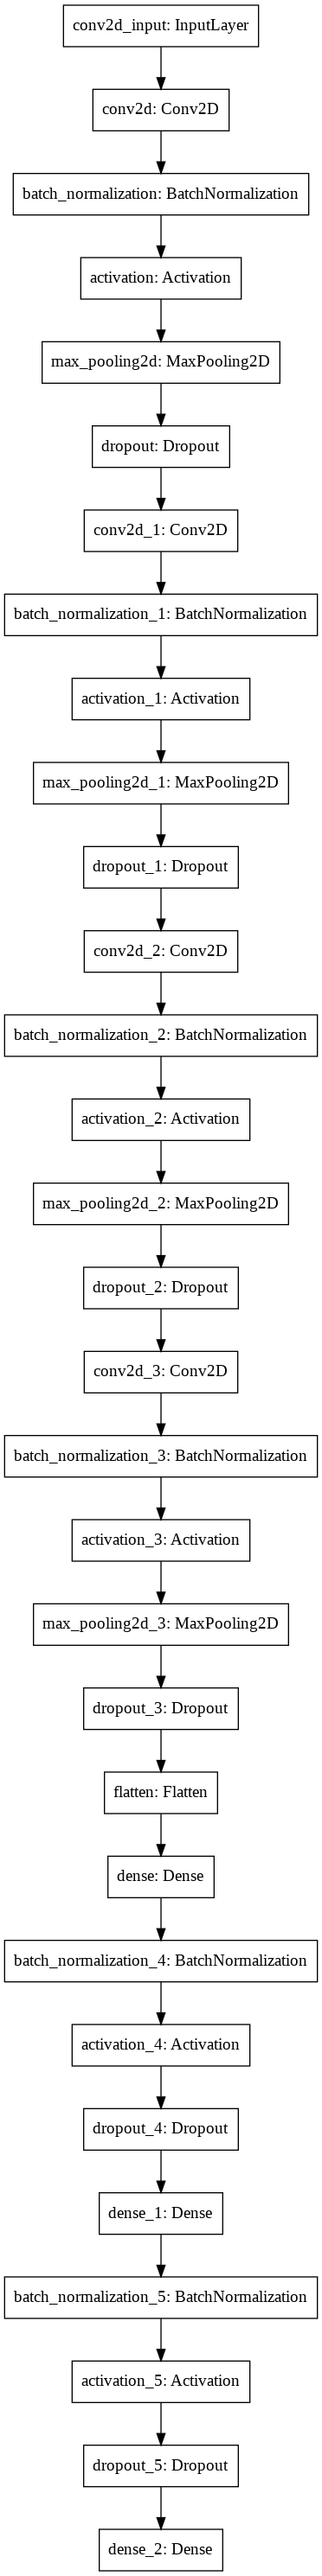

In [12]:

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb=ModelCheckpoint("Face_Expression_Model.h5",save_best_only=True)

model.summary()
plot_model(model)

In [13]:
%%time
epochs=50

history = model.fit_generator(generator=train_gen,
                                steps_per_epoch=train_gen.n//train_gen.batch_size,
                                epochs=epochs,
                                validation_data = validation_gen,
                                validation_steps = validation_gen.n//validation_gen.batch_size,
                                callbacks=[checkpoint_cb]
                                )


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
225/225 [==============================] - 10s 42ms/step - loss: 1.9887 - accuracy: 0.2369 - val_loss: 1.7111 - val_accuracy: 0.3206
Epoch 2/50
225/225 [==============================] - 9s 40ms/step - loss: 1.8121 - accuracy: 0.3001 - val_loss: 1.7597 - val_accuracy: 0.3233
Epoch 3/50
225/225 [==============================] - 9s 40ms/step - loss: 1.7037 - accuracy: 0.3452 - val_loss: 1.6430 - val_accuracy: 0.3663
Epoch 4/50
225/225 [==============================] - 9s 40ms/step - loss: 1.6319 - accuracy: 0.3742 - val_loss: 1.6151 - val_accuracy: 0.3893
Epoch 5/50
225/225 [==============================] - 9s 40ms/step - loss: 1.5709 - accuracy: 0.3963 - val_loss: 1.5215 - val_accuracy: 0.4193
Epoch 6/50
225/225 [==============================] - 9s 40ms/step - loss: 1.5286 - accuracy: 0.4125 - val_loss: 1.5173 - val_accuracy: 0.4146
Epoch 7/50
225/225 [==============================] - 9s 40ms/ste

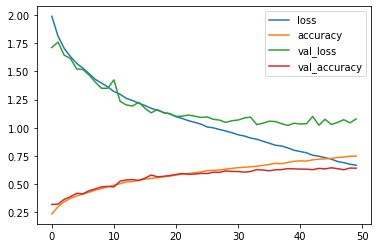

In [14]:
import pandas as pd
pd.DataFrame(history.history).plot()